# Semantic Embedding Analysis

This notebook analyzes semantic similarity between stakeholder comments and legislative drafts using sentence embeddings.

The analysis:
1. Embeds legal provisions and stakeholder comments using multilingual sentence transformers
2. Computes cosine similarity to measure semantic alignment
3. Tracks alignment shifts across draft versions
4. Examines document-level similarity between hearing letters and draft texts


## 1. Setup and Data Preparation


In [1]:
import re
import numpy as np
import pandas as pd

from typing import Optional, List, Dict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


EXCEL_PATH = "../data/geothermie_gesetz_kommentare.xlsx"
SHEET_NAME = "Gesetz + Kommentare"

df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
df.head()

,Artikel,Typ,Paragraph,Absatz,Gliederungspunkt_Nr,Gesetzestext_Entwurf_1_0307,Gesetzestext_Entwurf_2_1508,Gesetzestext_Entwurf_3_0110,Gesetzestext_Entwurf_4_0312,Org_2,...,Org_24,Org_25,Org_26,Org_27,Org_28,Org_29,Org_30,Org_31,Org_32,Org_33
0,1,Allgemeine Anmerkungen,-1,0,NaN,NaN,NaN,NaN,NaN,Der Beschleunigungseffekt des GeoBG erscheint ...,...,NaN,NaN,NaN,NaN,"Grundsätzlich ist ein Mehr an Geothermie, Sole...",Die Dekarbonisierung der Wärmeversorgung ist e...,s.o. § 1,NaN,NaN,NaN
1,1,Paragraph/Absatz,1,0,NaN,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,Zweck und Ziel des Gesetzes\nZweck dieses Gese...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Paragraph/Absatz,2,0,NaN,Anwendungsbereich\nDieses Gesetz ist anzuwende...,Anwendungsbereich\nDieses Gesetz ist anzuwende...,Anwendungsbereich\nDieses Gesetz ist anzuwende...,Anwendungsbereich\nDieses Gesetz ist anzuwende...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Paragraph/Absatz,3,0,NaN,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,Begriffsbestimmungen\nIm Sinne dieses Gesetzes...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Paragraph/Absatz,4,0,NaN,Überragendes öffentliches Interesse\nDie Erric...,Überragendes öffentliches Interesse\nDie Erric...,Überragendes öffentliches Interesse\nDie Erric...,Überragendes öffentliches Interesse\nDie Erric...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Pattern to match hyphenation across line breaks
HYPHEN_LINEBREAK_RE = re.compile(r"(\w+)-\s*\n\s*(\w+)", flags=re.UNICODE)

# optional: only if you really want to normalize slashes
SLASH_JOIN_RE = re.compile(r"(\w+)\s*/\s*(\w+)", flags=re.UNICODE)


def clean_legal_text(text: Optional[str]) -> str:
    """
    Cleans legal text while preserving semantic hyphenation.
    Only removes hyphens caused by line breaks (e.g. PDF artifacts).
    """
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return ""

    t = str(text)

    # Normalize line endings
    t = t.replace("\r\n", "\n").replace("\r", "\n")

    # Normalize tabs
    t = t.replace("\t", " ")

    # Remove hyphenation ONLY when caused by line breaks
    # Example: "Ther-\nmal" -> "Thermal"
    # Keeps: "Erdwärme-Anlage", "CO2-Preis"
    t = HYPHEN_LINEBREAK_RE.sub(r"\1\2", t)

    # Replace remaining newlines with spaces
    t = re.sub(r"\nn+", " ", t)

    # Optional: normalize slashed compounds (use with care)
    # Example: "Wärme-/Kältespeicher" -> "Wärme- und Kältespeicher"
    t = SLASH_JOIN_RE.sub(r"\1 und \2", t)

    # Collapse whitespace
    t = re.sub(r"\s+", " ", t).strip()

    return t

# apply to all columns
for col in df.columns:
    df[col] = df[col].astype(str).apply(clean_legal_text)

In [3]:
# Define draft version column names
DRAFT_COLS = [
    "Gesetzestext_Entwurf_1_0307",
    "Gesetzestext_Entwurf_2_1508",
    "Gesetzestext_Entwurf_3_0110",
    "Gesetzestext_Entwurf_4_0312",
]

META_COLS = ["Artikel", "Typ", "Paragraph", "Absatz", "Gliederungspunkt_Nr"]

def get_org_cols(df: pd.DataFrame) -> List[str]:
    return [c for c in df.columns if re.match(r"^Org_\d+$", c)]

In [4]:
df.head()

,Artikel,Typ,Paragraph,Absatz,Gliederungspunkt_Nr,Gesetzestext_Entwurf_1_0307,Gesetzestext_Entwurf_2_1508,Gesetzestext_Entwurf_3_0110,Gesetzestext_Entwurf_4_0312,Org_2,...,Org_24,Org_25,Org_26,Org_27,Org_28,Org_29,Org_30,Org_31,Org_32,Org_33
0,1,Allgemeine Anmerkungen,-1,0,nan,nan,nan,nan,nan,Der Beschleunigungseffekt des GeoBG erscheint ...,...,nan,nan,nan,nan,"Grundsätzlich ist ein Mehr an Geothermie, Sole...",Die Dekarbonisierung der Wärmeversorgung ist e...,s.o. § 1,nan,nan,nan
1,1,Paragraph und Absatz,1,0,nan,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,Zweck und Ziel des Gesetzes Zweck dieses Geset...,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,1,Paragraph und Absatz,2,0,nan,Anwendungsbereich Dieses Gesetz ist anzuwenden...,Anwendungsbereich Dieses Gesetz ist anzuwenden...,Anwendungsbereich Dieses Gesetz ist anzuwenden...,Anwendungsbereich Dieses Gesetz ist anzuwenden...,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,1,Paragraph und Absatz,3,0,nan,Begriffsbestimmungen Im Sinne dieses Gesetzes ...,Begriffsbestimmungen Im Sinne dieses Gesetzes ...,Begriffsbestimmungen Im Sinne dieses Gesetzes ...,Begriffsbestimmungen Im Sinne dieses Gesetzes ...,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,1,Paragraph und Absatz,4,0,nan,Überragendes öffentliches Interesse Die Errich...,Überragendes öffentliches Interesse Die Errich...,Überragendes öffentliches Interesse Die Errich...,Überragendes öffentliches Interesse Die Errich...,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## 2. Data Reshaping

Transform the data into a structure suitable for embedding analysis with aligned law text and comments.


In [5]:
import pandas as pd
import numpy as np

def reshape_law_and_comments_final(
    df: pd.DataFrame,
    law_version_cols: list[str],
    comment_cols: list[str],
    law_version_map: dict[str, str],
    key_cols: list[str] | None = None,
    typ_col: str = "Typ",
    general_typ_value: str = "Allgemeine Anmerkungen",
    drop_empty: bool = True,
) -> pd.DataFrame:
    """
    Create ONE final long dataframe with:
      - law text per version
      - stakeholder comments per organisation
      - aligned on the same law_unit_id

    Special rule:
      Rows with Typ == "Allgemeine Anmerkungen" receive the concatenated
      article-level law text (per version).

    Returns a dataframe with columns:
      key_cols + [
        "law_unit_id", "version", "law_text",
        "org", "comment_text",
        "law_text_len", "comment_text_len"
      ]
    """
    if key_cols is None:
        key_cols = ["Artikel", "Paragraph", "Absatz", "Gliederungspunkt_Nr"]

    d = df.copy()

    # ------------------------------------------------------------------
    # 1) Build article-level concatenated law text (exclude Allgemeine Anmerkungen)
    # ------------------------------------------------------------------
    non_general = d[typ_col] != general_typ_value
    article_text = (
        d.loc[non_general, ["Artikel"] + law_version_cols]
        .groupby("Artikel", dropna=False)[law_version_cols]
        .agg(lambda s: "\n".join(
            [str(x).strip() for x in s.dropna()
             if str(x).strip() and str(x).strip().lower() != "nan"]
        ))
        .reset_index()
    )

    # Attach article-level text and overwrite Allgemeine Anmerkungen rows
    d = d.merge(article_text, on="Artikel", how="left", suffixes=("", "_article"))
    is_general = d[typ_col] == general_typ_value
    for vcol in law_version_cols:
        d.loc[is_general, vcol] = d.loc[is_general, f"{vcol}_article"]
        d = d.drop(columns=f"{vcol}_article")

    # ------------------------------------------------------------------
    # 2) Stable law unit id
    # ------------------------------------------------------------------
    d["law_unit_id"] = (
        d[key_cols].astype(str).fillna("NA").agg("|".join, axis=1)
    )

    # ------------------------------------------------------------------
    # 3) LAW long (unit × version)
    # ------------------------------------------------------------------
    law_long = d.melt(
        id_vars=key_cols + ["law_unit_id"],
        value_vars=law_version_cols,
        var_name="version",
        value_name="law_text",
    )

    law_long["version"] = law_long["version"].map(law_version_map)
    law_long["law_text"] = law_long["law_text"].fillna("").astype(str)
    law_long["law_text_len"] = law_long["law_text"].str.len()

    # ------------------------------------------------------------------
    # 4) COMMENTS long (unit × organisation)
    # ------------------------------------------------------------------
    com_long = d.melt(
        id_vars=key_cols + ["law_unit_id"],
        value_vars=comment_cols,
        var_name="org",
        value_name="comment_text",
    )

    com_long["comment_text"] = com_long["comment_text"].fillna("").astype(str)
    com_long["comment_text_len"] = com_long["comment_text"].str.len()

    # ------------------------------------------------------------------
    # 5) FINAL JOIN → one dataframe
    # ------------------------------------------------------------------
    final_df = law_long.merge(
        com_long,
        on=key_cols + ["law_unit_id"],
        how="left",
    )

    if drop_empty:
        final_df = final_df[
            (final_df["law_text_len"] > 0) |
            (final_df["comment_text_len"] > 0)
        ].reset_index(drop=True)

    return final_df

ORG_COLS = get_org_cols(df)

df_emb = reshape_law_and_comments_final(
    df,
    law_version_cols=DRAFT_COLS,
    comment_cols=ORG_COLS,
    law_version_map={
        "Gesetzestext_Entwurf_1_0307": "Draft 1 (03.07)",
        "Gesetzestext_Entwurf_2_1508": "Draft 2 (15.08)",
        "Gesetzestext_Entwurf_3_0110": "Draft 3 (01.10)",
        "Gesetzestext_Entwurf_4_0312": "Draft 4 (03.12)",
    },
)

df_emb

,Artikel,Paragraph,Absatz,Gliederungspunkt_Nr,law_unit_id,version,law_text,law_text_len,org,comment_text,comment_text_len
0,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_2,Der Beschleunigungseffekt des GeoBG erscheint ...,727
1,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_3,Bereits jetzt kommt es jedoch durch den zunehm...,790
2,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_5,Ein wesentliches Hemmnis für den Bau geothermi...,783
3,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_6,nan,3
4,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_7,nan,3
...,...,...,...,...,...,...,...,...,...,...,...
6691,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_29,nan,3
6692,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_30,nan,3
6693,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_31,nan,3
6694,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_32,nan,3


In [6]:
print(df_emb.head())

  Artikel Paragraph Absatz Gliederungspunkt_Nr law_unit_id          version  \
0       1        -1      0                 nan  1|-1|0|nan  Draft 1 (03.07)   
1       1        -1      0                 nan  1|-1|0|nan  Draft 1 (03.07)   
2       1        -1      0                 nan  1|-1|0|nan  Draft 1 (03.07)   
3       1        -1      0                 nan  1|-1|0|nan  Draft 1 (03.07)   
4       1        -1      0                 nan  1|-1|0|nan  Draft 1 (03.07)   

                                            law_text  law_text_len    org  \
0  Zweck und Ziel des Gesetzes Zweck dieses Geset...         12585  Org_2   
1  Zweck und Ziel des Gesetzes Zweck dieses Geset...         12585  Org_3   
2  Zweck und Ziel des Gesetzes Zweck dieses Geset...         12585  Org_5   
3  Zweck und Ziel des Gesetzes Zweck dieses Geset...         12585  Org_6   
4  Zweck und Ziel des Gesetzes Zweck dieses Geset...         12585  Org_7   

                                        comment_text  comment_

## 3. Compute Embeddings and Similarity

Generate embeddings using sentence-transformers and compute cosine similarity between law provisions and stakeholder comments.


## Embedding analysis

In [7]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


def add_embeddings_and_similarity(
    df: pd.DataFrame,
    law_text_col: str = "law_text",
    comment_text_col: str = "comment_text",
    law_key_cols: list[str] | None = None,      # identifies unique law text units
    comment_key_cols: list[str] | None = None,  # identifies unique comment units
    model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    batch_size: int = 64,
) -> pd.DataFrame:
    """
    Adds embeddings + cosine similarity to a df that has repeated law_text per org and often missing comments.

    Key behavior:
      - Embeds each unique (law_unit_id, version) law_text once.
      - Embeds each unique (law_unit_id, org) comment_text once.
      - Treats empty / 'nan' / whitespace-only comments as missing and does NOT embed them.
      - Similarity is computed only where a real comment exists; otherwise sim = NaN.

    Returns:
      df_out with added columns:
        - law_emb (np.ndarray)
        - comment_emb (np.ndarray)
        - sim_emb (float)
    """
    if law_key_cols is None:
        law_key_cols = ["law_unit_id", "version"]
    if comment_key_cols is None:
        comment_key_cols = ["law_unit_id", "org"]

    d = df.copy()

    # --------- 0) Clean up "nan" strings and empties (IMPORTANT) ----------
    def _norm_text(x) -> str:
        if x is None:
            return ""
        s = str(x)
        if s.strip().lower() in {"nan", "none", ""}:
            return ""
        return s.strip()

    d[law_text_col] = d[law_text_col].apply(_norm_text)
    d[comment_text_col] = d[comment_text_col].apply(_norm_text)

    # --------- 1) Build unique LAW table: (law_unit_id, version) ----------
    law_unique = (
        d[law_key_cols + [law_text_col]]
        .drop_duplicates(subset=law_key_cols)
        .copy()
    )
    law_unique = law_unique[law_unique[law_text_col].str.len() > 0].reset_index(drop=True)

    # --------- 2) Build unique COMMENT table: (law_unit_id, org) ----------
    com_unique = (
        d[comment_key_cols + [comment_text_col]]
        .drop_duplicates(subset=comment_key_cols)
        .copy()
    )
    com_unique = com_unique[com_unique[comment_text_col].str.len() > 0].reset_index(drop=True)

    # --------- 3) Compute embeddings once ----------
    model = SentenceTransformer(model_name)

    if len(law_unique) > 0:
        law_emb = model.encode(
            law_unique[law_text_col].tolist(),
            batch_size=batch_size,
            convert_to_numpy=True,
            normalize_embeddings=True,  # makes cosine just dot product
            show_progress_bar=True,
        )
        law_unique["law_emb"] = list(law_emb)
    else:
        law_unique["law_emb"] = []

    if len(com_unique) > 0:
        com_emb = model.encode(
            com_unique[comment_text_col].tolist(),
            batch_size=batch_size,
            convert_to_numpy=True,
            normalize_embeddings=True,
            show_progress_bar=True,
        )
        com_unique["comment_emb"] = list(com_emb)
    else:
        com_unique["comment_emb"] = []

    # --------- 4) Merge embeddings back ----------
    d = d.merge(law_unique[law_key_cols + ["law_emb"]], on=law_key_cols, how="left")
    d = d.merge(com_unique[comment_key_cols + ["comment_emb"]], on=comment_key_cols, how="left")

    # --------- 5) Cosine similarity (only where comment exists) ----------
    # Because embeddings are normalized, cosine = dot product.
    def _dot_or_nan(a, b):
        if isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
            return float(np.dot(a, b))
        return np.nan

    d["sim_emb"] = [
        _dot_or_nan(a, b) for a, b in zip(d["law_emb"].values, d["comment_emb"].values)
    ]

    return d

df_emb = add_embeddings_and_similarity(
    df_emb,
    law_text_col="law_text",
    comment_text_col="comment_text",
    law_key_cols=["law_unit_id", "version"],
    comment_key_cols=["law_unit_id", "org"],
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    batch_size=64,
)

/Users/elena/miniconda3/envs/.venv-dl-ps1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


In [8]:
df_emb

,Artikel,Paragraph,Absatz,Gliederungspunkt_Nr,law_unit_id,version,law_text,law_text_len,org,comment_text,comment_text_len,law_emb,comment_emb,sim_emb
0,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_2,Der Beschleunigungseffekt des GeoBG erscheint ...,727,"[-0.026573248, 0.06936995, -0.0747335, 0.03507...","[-0.016502604, -0.023942478, 0.04251062, -0.06...",0.414615
1,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_3,Bereits jetzt kommt es jedoch durch den zunehm...,790,"[-0.026573248, 0.06936995, -0.0747335, 0.03507...","[0.0857169, 0.027137062, 0.011020614, 0.040890...",0.260944
2,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_5,Ein wesentliches Hemmnis für den Bau geothermi...,783,"[-0.026573248, 0.06936995, -0.0747335, 0.03507...","[-0.0551664, 0.06872597, 0.047666617, 0.041001...",0.513061
3,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_6,,3,"[-0.026573248, 0.06936995, -0.0747335, 0.03507...",NaN,NaN
4,1,-1,0,nan,1|-1|0|nan,Draft 1 (03.07),Zweck und Ziel des Gesetzes Zweck dieses Geset...,12585,Org_7,,3,"[-0.026573248, 0.06936995, -0.0747335, 0.03507...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_29,,3,"[-0.03485735, 0.13631585, 0.011139268, 0.08957...",NaN,NaN
6692,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_30,,3,"[-0.03485735, 0.13631585, 0.011139268, 0.08957...",NaN,NaN
6693,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_31,,3,"[-0.03485735, 0.13631585, 0.011139268, 0.08957...",NaN,NaN
6694,10,0,0,0.0,10|0|0|0.0,Draft 4 (03.12),Änderung des Wärmeplanungsgesetzes Das Wärmepl...,207,Org_32,,3,"[-0.03485735, 0.13631585, 0.011139268, 0.08957...",NaN,NaN


## 4. Alignment Shift Analysis

Analyze how semantic alignment between comments and drafts changes over time (Δ similarity).


In [9]:
import numpy as np
import pandas as pd

def compute_dsim_by_org(
    df_emb: pd.DataFrame,
    version_col: str = "version",
    org_col: str = "org",
    sim_col: str = "sim_emb",
    v0_label: str = "Draft 1 (03.07)",
    v1_label: str = "Draft 2 (15.08)",
    v3_label: str = "Draft 4 (03.12)",
) -> pd.DataFrame:
    """
    Compute Δsim per organisation:
      - Δsim_v1_v0 = sim(v1) - sim(v0)
      - Δsim_v3_v0 = sim(v3) - sim(v0)

    Uses the mean similarity per (org, version) across all law units where a similarity exists.
    Missing sims are ignored. If an org has no sims for a version, the result is NaN.
    """
    d = df_emb.copy()

    # keep only rows where similarity exists (i.e., real comment + law text)
    d = d[d[sim_col].notna()].copy()

    # mean similarity per org x version
    org_ver = (
        d.groupby([org_col, version_col], dropna=False)[sim_col]
         .mean()
         .reset_index()
         .rename(columns={sim_col: "mean_sim"})
    )

    # pivot to wide: one row per org, columns are versions
    wide = org_ver.pivot(index=org_col, columns=version_col, values="mean_sim")

    # compute deltas
    out = pd.DataFrame(index=wide.index)
    out["mean_sim_v0"] = wide.get(v0_label, np.nan)
    out["mean_sim_v1"] = wide.get(v1_label, np.nan)
    out["mean_sim_v3"] = wide.get(v3_label, np.nan)

    out["dsim_v1_minus_v0"] = out["mean_sim_v1"] - out["mean_sim_v0"]
    out["dsim_v3_minus_v0"] = out["mean_sim_v3"] - out["mean_sim_v0"]

    # counts (how many paragraph comparisons per org per version)
    counts = (
        d.groupby([org_col, version_col], dropna=False)[sim_col]
         .size()
         .reset_index(name="n_pairs")
         .pivot(index=org_col, columns=version_col, values="n_pairs")
    )
    out["n_pairs_v0"] = counts.get(v0_label, np.nan)
    out["n_pairs_v1"] = counts.get(v1_label, np.nan)
    out["n_pairs_v3"] = counts.get(v3_label, np.nan)

    out = out.reset_index().rename(columns={org_col: "org"})

    # optional: sort by largest increase to final vs baseline
    out = out.sort_values("dsim_v3_minus_v0", ascending=False)

    return out


In [10]:
df_dsim = compute_dsim_by_org(
    df_emb,
    v0_label="Draft 1 (03.07)",
    v1_label="Draft 2 (15.08)",
    v3_label="Draft 4 (03.12)",
)

df_dsim

,org,mean_sim_v0,mean_sim_v1,mean_sim_v3,dsim_v1_minus_v0,dsim_v3_minus_v0,n_pairs_v0,n_pairs_v1,n_pairs_v3
24,Org_33,0.435882,0.581697,0.582658,0.145816,0.146777,1,1,1
29,Org_9,0.582282,0.644987,0.640052,0.062705,0.057770,2,2,2
17,Org_26,0.341882,0.373432,0.373222,0.031551,0.031340,5,6,6
26,Org_6,0.773702,0.812423,0.801332,0.038721,0.027631,1,1,1
9,Org_19,0.434747,0.434747,0.460498,0.000000,0.025751,2,2,2
8,Org_18,0.449477,0.472330,0.475112,0.022854,0.025635,3,3,3
25,Org_5,0.564434,0.583332,0.586259,0.018898,0.021825,8,8,8
6,Org_16,0.539233,0.561255,0.556321,0.022022,0.017088,14,14,14
28,Org_8,0.603640,0.617663,0.616264,0.014024,0.012624,3,3,3
10,Org_2,0.590812,0.601131,0.602061,0.010319,0.011249,11,11,11


In [11]:
# Load organization metadata
org_map = pd.read_excel(EXCEL_PATH, sheet_name="Org_Map")

# rename Org_ID column for merging
org_map = org_map.rename(columns={"Org_ID": "Org_Col"})

In [12]:
# Merge organization metadata with similarity results
df_dsim = df_dsim.merge(
    org_map,
    left_on="org",
    right_on="Org_Col",
    how="left",
)

# harmonize "Organisation_Name" --> no _x, _y suffixes
df_dsim = df_dsim.rename(columns={"Organisation_Name_y": "Organisation_Name"})
#df_dsim = df_dsim.drop(columns=["Organisation_Name_x"])

In [13]:
df_dsim

,org,mean_sim_v0,mean_sim_v1,mean_sim_v3,dsim_v1_minus_v0,dsim_v3_minus_v0,n_pairs_v0,n_pairs_v1,n_pairs_v3,Org_Col,Organisation_Name,Organisation_Typ
0,Org_33,0.435882,0.581697,0.582658,0.145816,0.146777,1,1,1,Org_33,Verband der Kali- und Salzindustrie,Wirtschaftsverband
1,Org_9,0.582282,0.644987,0.640052,0.062705,0.057770,2,2,2,Org_9,DVGW - Deutscher Verein des Gas- und Wasserfac...,Andere
2,Org_26,0.341882,0.373432,0.373222,0.031551,0.031340,5,6,6,Org_26,Oberbergamt des Saarlandes,Land/Landesbehörde
3,Org_6,0.773702,0.812423,0.801332,0.038721,0.027631,1,1,1,Org_6,Hauptstadtbüro Bioenergie,Wirtschaftsverband
4,Org_19,0.434747,0.434747,0.460498,0.000000,0.025751,2,2,2,Org_19,Verband der industriellen Energie- und Kraftwi...,Wirtschaftsverband
5,Org_18,0.449477,0.472330,0.475112,0.022854,0.025635,3,3,3,Org_18,Kunststoffrohrverband e.V.,Wirtschaftsverband
6,Org_5,0.564434,0.583332,0.586259,0.018898,0.021825,8,8,8,Org_5,"Ministerium für Wirtschaft, Infrastruktur, Tou...",Land/Landesbehörde
7,Org_16,0.539233,0.561255,0.556321,0.022022,0.017088,14,14,14,Org_16,"Bundesverband Erdgas, Erdöl und Geoenergie e.V...",Wirtschaftsverband
8,Org_8,0.603640,0.617663,0.616264,0.014024,0.012624,3,3,3,Org_8,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband
9,Org_2,0.590812,0.601131,0.602061,0.010319,0.011249,11,11,11,Org_2,Deutsche Umwelthilfe e.V.,Umweltverband


In [14]:
# Select and reorder columns for clarity
df_dsim = df_dsim[
    ["org", "Organisation_Name", "Organisation_Typ",
     "mean_sim_v0", "mean_sim_v1", "mean_sim_v3",
     "dsim_v1_minus_v0", "dsim_v3_minus_v0",
     "n_pairs_v0", "n_pairs_v1", "n_pairs_v3"]
]

In [15]:
df_dsim

,org,Organisation_Name,Organisation_Typ,mean_sim_v0,mean_sim_v1,mean_sim_v3,dsim_v1_minus_v0,dsim_v3_minus_v0,n_pairs_v0,n_pairs_v1,n_pairs_v3
0,Org_33,Verband der Kali- und Salzindustrie,Wirtschaftsverband,0.435882,0.581697,0.582658,0.145816,0.146777,1,1,1
1,Org_9,DVGW - Deutscher Verein des Gas- und Wasserfac...,Andere,0.582282,0.644987,0.640052,0.062705,0.057770,2,2,2
2,Org_26,Oberbergamt des Saarlandes,Land/Landesbehörde,0.341882,0.373432,0.373222,0.031551,0.031340,5,6,6
3,Org_6,Hauptstadtbüro Bioenergie,Wirtschaftsverband,0.773702,0.812423,0.801332,0.038721,0.027631,1,1,1
4,Org_19,Verband der industriellen Energie- und Kraftwi...,Wirtschaftsverband,0.434747,0.434747,0.460498,0.000000,0.025751,2,2,2
5,Org_18,Kunststoffrohrverband e.V.,Wirtschaftsverband,0.449477,0.472330,0.475112,0.022854,0.025635,3,3,3
6,Org_5,"Ministerium für Wirtschaft, Infrastruktur, Tou...",Land/Landesbehörde,0.564434,0.583332,0.586259,0.018898,0.021825,8,8,8
7,Org_16,"Bundesverband Erdgas, Erdöl und Geoenergie e.V...",Wirtschaftsverband,0.539233,0.561255,0.556321,0.022022,0.017088,14,14,14
8,Org_8,Bundesverband Deutscher Wasserkraftwerke (BDW)...,Wirtschaftsverband,0.603640,0.617663,0.616264,0.014024,0.012624,3,3,3
9,Org_2,Deutsche Umwelthilfe e.V.,Umweltverband,0.590812,0.601131,0.602061,0.010319,0.011249,11,11,11


## 5. Visualization

Visualize alignment shifts by organization type.


/var/folders/96/d0b81fgx57nf5q8xrlw36p1w0000gn/T/ipykernel_72363/4018780755.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


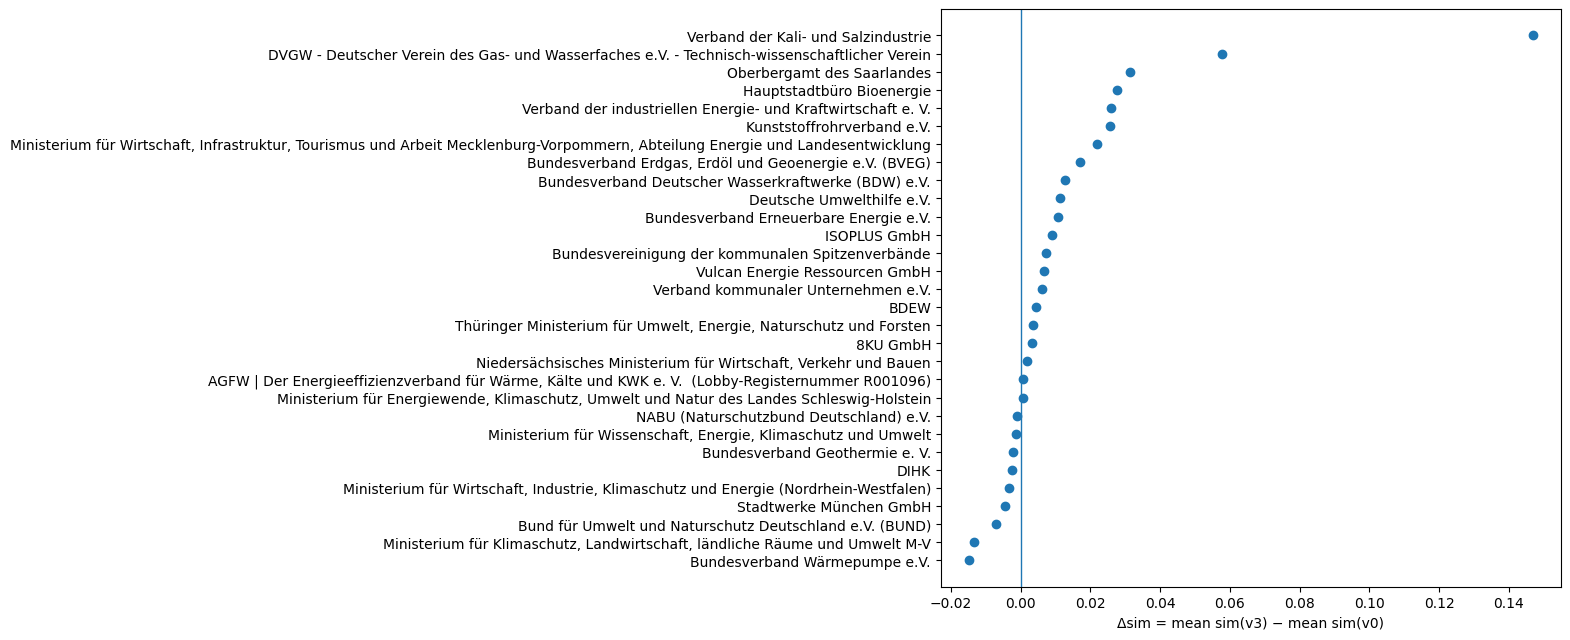

In [16]:
import matplotlib.pyplot as plt
import numpy as np

tmp = df_dsim.dropna(subset=["dsim_v3_minus_v0"]).copy()
tmp = tmp.sort_values("dsim_v3_minus_v0")
labels = tmp["Organisation_Name"].fillna(tmp["org"]).astype(str)

plt.figure(figsize=(8, max(4, 0.25 * len(tmp))))
plt.scatter(tmp["dsim_v3_minus_v0"], np.arange(len(tmp)))
plt.yticks(np.arange(len(tmp)), labels)
plt.axvline(0, linewidth=1)
plt.xlabel("Δsim = mean sim(v3) − mean sim(v0)")
plt.ylabel("")
plt.tight_layout()
plt.show()

/var/folders/96/d0b81fgx57nf5q8xrlw36p1w0000gn/T/ipykernel_72363/3997522599.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order_pretty)


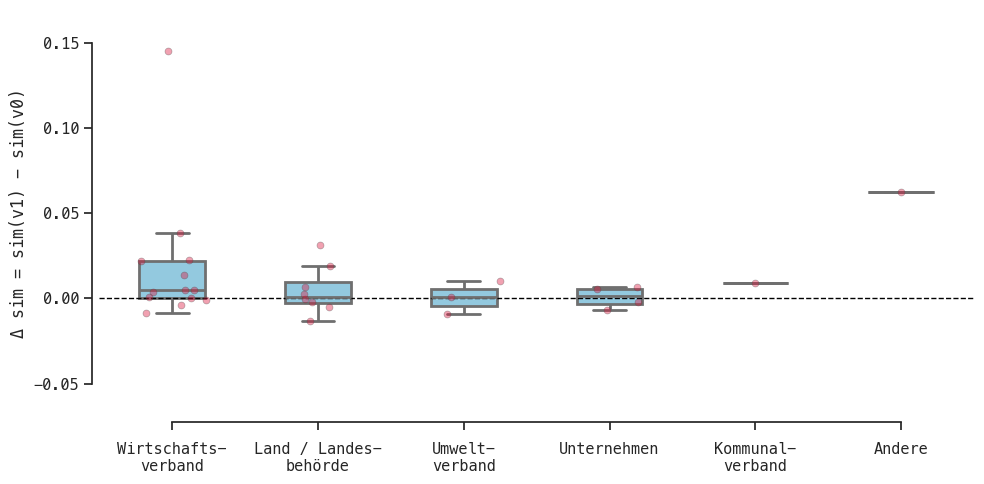

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define display labels for organization types
order_pretty = [
    "Wirtschafts-\nverband",
    "Land / Landes-\nbehörde",
    "Umwelt-\nverband",
    "Unternehmen",
    "Kommunal-\nverband",
    "Andere",
]

# Raw labels (what exists in your DATAFRAME)
order_raw = [
    "Wirtschaftsverband",
    "Land/Landesbehörde",
    "Umweltverband ",
    "Unternehmen",
    "Kommunalverband",
    "Andere",
]

# -----------------------------
# Global style
# -----------------------------
sns.set(
    style="ticks",
    rc={
        "figure.figsize": (10, 5),
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "font.family": "monospace",
        "font.monospace": ["Menlo"],
    },
)

tmp = df_dsim.dropna(subset=["Organisation_Typ", "dsim_v1_minus_v0"]).copy()

# -----------------------------
# Boxplot
# -----------------------------
ax = sns.boxplot(
    data=tmp,
    x="Organisation_Typ",
    y="dsim_v1_minus_v0",
    order=order_raw,
    width=0.45,
    color="skyblue",
    linewidth=2,
    showfliers=False,
)

# -----------------------------
# Stripplot (dots)
# -----------------------------
sns.stripplot(
    data=tmp,
    x="Organisation_Typ",
    y="dsim_v1_minus_v0",
    order=order_raw,
    color="crimson",
    alpha=0.4,
    jitter=0.25,
    size=5,
    linewidth=0.5,
)

# Zero line
ax.axhline(0, color="black", linewidth=1, linestyle="--")

# Stretch y-scale (more room below 0 if you want, adjust 0.35 / 0.15)
y = tmp["dsim_v1_minus_v0"]
rng = (y.max() - y.min()) if (y.max() - y.min()) != 0 else 1.0
lower = y.min() - 0.35 * rng
upper = y.max() + 0.15 * rng
ax.set_ylim(lower, upper)

# Labels
ax.set_ylabel("Δ sim = sim(v1) − sim(v0)", fontsize=12)
ax.set_xlabel("")

# Tick label formatting (rotation + distance)
ax.tick_params(axis="x", pad=8)

# Replace tick text with your pretty, line-broken labels
ax.set_xticklabels(order_pretty)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha("right")
    label.set_va("top")

plt.subplots_adjust(bottom=0.28)

sns.despine(offset=5, trim=True)
plt.tight_layout()
plt.show()

## 6. Document-Level Analysis

Analyze full stakeholder letters from the parliamentary hearing against complete draft versions.


### Whole documents analysis (2nd consultation draft vs comments)

In [18]:
import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from pathlib import Path


# -------------------------
# 0) Text utilities
# -------------------------
def normalize_text(x) -> str:
    """Normalize whitespace; convert None/NaN/'nan' to empty string."""
    if x is None:
        return ""
    s = str(x)
    if s.strip().lower() in {"nan", "none"}:
        return ""
    s = s.replace("\t", " ").replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\n+", "\n", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()


def chunk_text_whitespace(text: str, max_chars: int = 3500) -> list[str]:
    """Chunk long text without cutting words (simple packing)."""
    text = normalize_text(text)
    if not text:
        return []

    words = text.split(" ")
    chunks, cur = [], []
    cur_len = 0

    for w in words:
        add_len = len(w) + (1 if cur else 0)
        if cur_len + add_len > max_chars:
            chunks.append(" ".join(cur))
            cur = [w]
            cur_len = len(w)
        else:
            cur.append(w)
            cur_len += add_len

    if cur:
        chunks.append(" ".join(cur))
    return chunks


# -------------------------
# 1) Build full-law docs per version
# -------------------------
def build_law_docs(df_law: pd.DataFrame, draft_cols: dict[str, str]) -> dict[str, str]:
    """Return {version: concatenated law text}."""
    docs = {}
    for version, col in draft_cols.items():
        tmp = df_law.copy()

        # exclude article-note rows if present
        if "Typ" in tmp.columns:
            tmp = tmp[tmp["Typ"] != "Allgemeine Anmerkungen"]

        texts = tmp[col].apply(normalize_text).tolist()
        texts = [t for t in texts if t]  # drop empties

        docs[version] = "\n\n".join(texts)

    return docs


# -------------------------
# 2) Load letters
# -------------------------
def load_letters_from_folder(folder_path: str, encoding: str = "utf-8") -> pd.DataFrame:
    folder = Path(folder_path)
    records = []

    for p in sorted(folder.glob("*.txt")):
        try:
            text = p.read_text(encoding=encoding)
        except UnicodeDecodeError:
            text = p.read_text(encoding="latin-1")

        records.append({"letter_id": p.stem, "letter_text": text})

    out = pd.DataFrame(records)
    out["letter_text"] = out["letter_text"].apply(normalize_text)
    out = out[out["letter_text"].str.len() > 0].reset_index(drop=True)
    return out


# -------------------------
# 3) Embedding helpers (using the SAME model as before)
# -------------------------
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(MODEL_NAME)

def embed_chunks(texts: list[str], batch_size: int = 64) -> np.ndarray:
    """
    Returns normalized embeddings with shape (n_texts, d).
    normalize_embeddings=True => cosine = dot product later.
    """
    return model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=True,
        show_progress_bar=False,
    )

def embed_document(text: str, max_chars: int = 3500) -> np.ndarray:
    """
    Chunk document, embed chunks, average (then normalize).
    Returns (d,) vector.
    """
    chunks = chunk_text_whitespace(text, max_chars=max_chars)
    if len(chunks) == 0:
        raise ValueError("Tried to embed an empty document.")

    E = embed_chunks(chunks)  # (n_chunks, d), already normalized
    doc = E.mean(axis=0)
    doc = doc / (np.linalg.norm(doc) + 1e-12)
    return doc


def cosine_sim(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Cosine similarity matrix; expects 2D arrays."""
    A = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-12)
    B = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-12)
    return A @ B.T


# -------------------------
# 4) Run the pipeline
# -------------------------
draft_cols = {
    "v0": "Gesetzestext_Entwurf_1_0307",
    "v1": "Gesetzestext_Entwurf_2_1508",
    "v2": "Gesetzestext_Entwurf_3_0110",
    "v3": "Gesetzestext_Entwurf_4_0312",
}

law_docs = build_law_docs(df, draft_cols)

draft_keys = ["v0", "v1", "v2", "v3"]
emb_law = np.vstack([embed_document(law_docs[k]) for k in draft_keys])  # (4, d)

LETTERS_DIR = "../data/processed/anhoerung_txt"
df_letters = load_letters_from_folder(LETTERS_DIR)

emb_letters = np.vstack([embed_document(t) for t in df_letters["letter_text"]])  # (n_letters, d)

S = cosine_sim(emb_letters, emb_law)  # (n_letters, 4)

sim_df = pd.DataFrame(S, columns=[f"sim_letter_to_{k}" for k in draft_keys])
sim_df.insert(0, "letter_id", df_letters["letter_id"].values)

sim_df["delta_v1_minus_v0"] = sim_df["sim_letter_to_v1"] - sim_df["sim_letter_to_v0"]
sim_df["delta_v3_minus_v0"] = sim_df["sim_letter_to_v3"] - sim_df["sim_letter_to_v0"]

sim_df


,letter_id,sim_letter_to_v0,sim_letter_to_v1,sim_letter_to_v2,sim_letter_to_v3,delta_v1_minus_v0,delta_v3_minus_v0
0,BDEW_Bundesverband_der_Energie_und_Wasserwirts...,0.795070,0.834565,0.816382,0.805880,0.039495,0.010811
1,Bundesverbandes_Geothermie_eV,0.844410,0.870864,0.853218,0.866874,0.026455,0.022464
2,Bundesvereinigung_der_kommunalen_Spitzenverbände,0.783803,0.787191,0.789462,0.824766,0.003388,0.040963
3,Deutschen_Umwelthilfe_eV,0.799338,0.794415,0.812922,0.838311,-0.004923,0.038974
4,Sachverständigen_Fabian_Ahrendts_Fraunhofer_IEG,0.681799,0.752731,0.723379,0.730319,0.070932,0.048520
5,Sachverständigen_Prof_Dr_Sven_Joachim_Otto_Dir...,0.789065,0.804497,0.810195,0.780257,0.015432,-0.008808
6,Stadtwerke_Muenchen,0.875592,0.918294,0.916764,0.924664,0.042701,0.049072


In [19]:
print(sim_df)

                                           letter_id  sim_letter_to_v0  \
0  BDEW_Bundesverband_der_Energie_und_Wasserwirts...          0.795070   
1                      Bundesverbandes_Geothermie_eV          0.844410   
2   Bundesvereinigung_der_kommunalen_Spitzenverbände          0.783803   
3                           Deutschen_Umwelthilfe_eV          0.799338   
4    Sachverständigen_Fabian_Ahrendts_Fraunhofer_IEG          0.681799   
5  Sachverständigen_Prof_Dr_Sven_Joachim_Otto_Dir...          0.789065   
6                                Stadtwerke_Muenchen          0.875592   

   sim_letter_to_v1  sim_letter_to_v2  sim_letter_to_v3  delta_v1_minus_v0  \
0          0.834565          0.816382          0.805880           0.039495   
1          0.870864          0.853218          0.866874           0.026455   
2          0.787191          0.789462          0.824766           0.003388   
3          0.794415          0.812922          0.838311          -0.004923   
4          0.7527

/var/folders/96/d0b81fgx57nf5q8xrlw36p1w0000gn/T/ipykernel_72363/1582832148.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


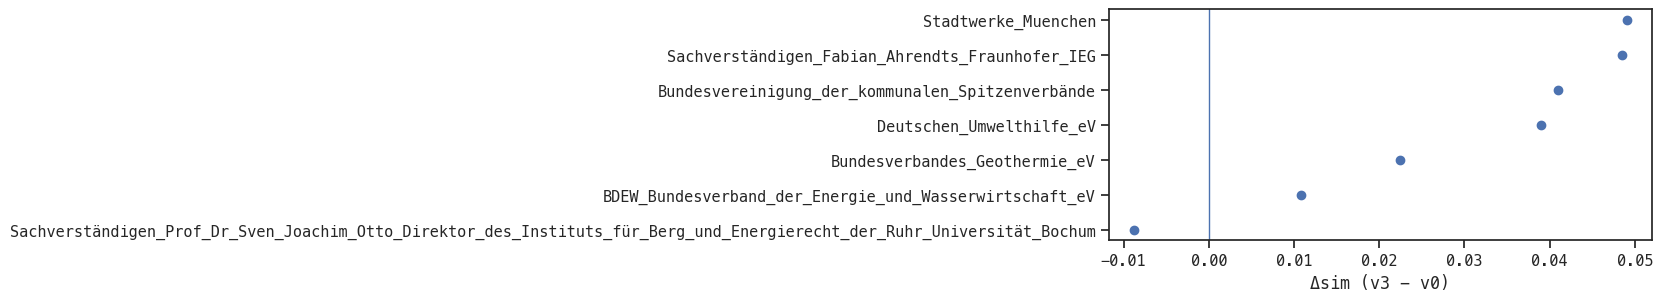

In [20]:
import matplotlib.pyplot as plt
import numpy as np

tmp = sim_df.copy().sort_values("delta_v3_minus_v0")

plt.figure(figsize=(7, 3))
plt.scatter(tmp["delta_v3_minus_v0"], np.arange(len(tmp)))
plt.yticks(np.arange(len(tmp)), tmp["letter_id"])
plt.axvline(0, linewidth=1)
plt.xlabel("Δsim (v3 − v0)")
plt.ylabel("")
plt.tight_layout()
plt.show()


## 7. Textual Comparison

Visual comparison of specific provisions showing convergence between stakeholder proposals and final text.


In [21]:
import re
import difflib
from typing import List, Tuple, Set
from IPython.display import HTML, display


def _tokenize(text: str) -> List[str]:
    """
    Tokenize while preserving line breaks.
    Newlines are kept as explicit tokens.
    """
    text = "" if text is None else str(text)
    if not text.strip():
        return []

    # split into words, punctuation, and newlines
    return re.findall(
        r"\n|[A-Za-zÄÖÜäöüß0-9]+|[^\w\s]",
        text,
        flags=re.UNICODE,
    )


def _escape_html(s: str) -> str:
    return (
        s.replace("&", "&amp;")
         .replace("<", "&lt;")
         .replace(">", "&gt;")
         .replace('"', "&quot;")
         .replace("'", "&#39;")
    )


def _opcodes(a: List[str], b: List[str]) -> List[Tuple[str, int, int, int, int]]:
    return difflib.SequenceMatcher(a=a, b=b, autojunk=False).get_opcodes()


def _added_token_positions(v0_toks: List[str], v3_toks: List[str]) -> Set[int]:
    added = set()
    for tag, i1, i2, j1, j2 in _opcodes(v0_toks, v3_toks):
        if tag in ("insert", "replace"):
            added.update(range(j1, j2))
    return added


def _matched_positions_in_b(a: List[str], b: List[str]) -> Set[int]:
    matched = set()
    for tag, i1, i2, j1, j2 in _opcodes(a, b):
        if tag == "equal":
            matched.update(range(j1, j2))
    return matched

def _strip_leading_blank_lines_keep_rest(s: str) -> str:
    s = "" if s is None else str(s)
    # remove leading whitespace-only lines, but keep internal line breaks intact
    s = re.sub(r"^(?:[ \t]*\n)+", "", s)
    return s


def render_threeway_alignment_html(
    v0_text: str,
    letter_text: str,
    v3_text: str,
    max_tokens: int = 450,
    title_left: str = "Law v0",
    title_mid: str = "Letter (Organisation)",
    title_right: str = "Law v3",
) -> None:

    v0_text = _strip_leading_blank_lines_keep_rest(v0_text)
    letter_text = _strip_leading_blank_lines_keep_rest(letter_text)
    v3_text = _strip_leading_blank_lines_keep_rest(v3_text)

    v0 = _tokenize(v0_text)[:max_tokens]
    lt = _tokenize(letter_text)[:max_tokens]
    v3 = _tokenize(v3_text)[:max_tokens]


    if not v3:
        display(HTML("<b>v3 text is empty after tokenization.</b>"))
        return

    added_v3 = _added_token_positions(v0, v3)
    matched_v3 = _matched_positions_in_b(lt, v3)
    matched_letter = _matched_positions_in_b(v3, lt)


    PUNCT_NO_SPACE_BEFORE = {",", ";", ":", "!", "?", ".", ")", "]", "}", "%"}
    PUNCT_NO_SPACE_AFTER = {"(", "[", "{"}

    def _render_token(tok: str, tok_html: str, next_tok: str | None) -> str:
        if tok == "\n":
            return "\n"

        # Decide whether to add a trailing space AFTER this token.
        add_space = True

        # No space after opening brackets: "(" -> no trailing space
        if tok in PUNCT_NO_SPACE_AFTER:
            add_space = False

        # No space before punctuation like "," "." ")" etc. is handled by the PREVIOUS token:
        # If the next token is punctuation, do NOT add a trailing space now.
        if next_tok in PUNCT_NO_SPACE_BEFORE:
            add_space = False

        # End of sequence: no trailing space
        if next_tok is None:
            add_space = False

        return tok_html + (" " if add_space else "")

    def span(tok: str, next_tok: str | None, bg: str | None = None) -> str:
        if tok == "\n":
            return "\n"

        tok_html = _escape_html(tok)
        if bg is not None:
            tok_html = (
                f"<span style='background:{bg}; padding:1px 2px; border-radius:4px;'>"
                f"{tok_html}</span>"
            )
        return _render_token(tok, tok_html, next_tok)

    # def _strip_leading(tokens):
    #     i = 0
    #     while i < len(tokens) and tokens[i] in {"\n"}:
    #         i += 1
    #     return tokens[i:]


    # v0 = _strip_leading(v0)
    # lt = _strip_leading(lt)
    # v3 = _strip_leading(v3)

    def render_tokens(tokens: List[str], bg_for_index) -> str:
        out = []
        for i, tok in enumerate(tokens):
            next_tok = tokens[i + 1] if i + 1 < len(tokens) else None
            out.append(span(tok, next_tok, bg=bg_for_index(i, tok)))
        html = "".join(out)
        # remove any accidental leading whitespace
        return html.lstrip()

    v0_html = render_tokens(v0, lambda i, tok: None) if v0 else "<i>(empty)</i>"

    letter_html = render_tokens(
        lt,
        lambda i, tok: "#d8f5d8" if i in matched_letter else "#ffd6d6"
    ) if lt else "<i>(empty)</i>"

    v3_html = render_tokens(
        v3,
        lambda j, tok: "#d8f5d8" if (j in added_v3 and j in matched_v3)
        else "#fff2b3" if j in added_v3
        else None
    )


    html = f"""
    <div style="font-family: system-ui, -apple-system, Segoe UI, Roboto, sans-serif;">
      <table style="width:100%; border-collapse:separate; border-spacing:12px;">
        <tr>
          <th style="text-align:center; width:33%; font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace">{_escape_html(title_left)}</th>
          <th style="text-align:center; width:34%; font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace">{_escape_html(title_mid)}</th>
          <th style="text-align:center; width:33%; font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace">{_escape_html(title_right)}</th>
        </tr>
        <tr>
          <td style="
            margin:10px;
            vertical-align:top;
            border:1px solid #ddd;
            border-radius:10px;
            padding:10px;
            line-height:1.6;
            white-space: pre-wrap;
            text-align: left;
            font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace;">
            {v0_html}
          </td>
          <td style="
            vertical-align:top;
            border:1px solid #ddd;
            border-radius:10px;
            padding:10px;
            line-height:1.6;
            white-space: pre-wrap;
            text-align: left;
            font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace;">
            {letter_html}
          </td>
          <td style="
            vertical-align:top;
            border:1px solid #ddd;
            border-radius:10px;
            padding:10px;
            line-height:1.6;
            white-space: pre-wrap;
            text-align: left;
            font-family: ui-monospace, SFMono-Regular, Menlo, Monaco, Consolas, 'Liberation Mono', 'Courier New', monospace;">
            {v3_html}
          </td>
        </tr>
      </table>
    </div>
    """
    display(HTML(html))

In [33]:
v0_excerpt = """
§ 8 Planfeststellung, Plangenehmigung
(1)…
(2) Für das Planfeststellungsverfahren sowie für das Plangenehmigungsverfahren nach Absatz 1 gelten die Vorschriften des Teil V Abschnitt 2 des Verwaltungsverfahrensgesetzes.

Dabei sind entsprechend anzuwenden

1. die Maßgaben der § 43a, des Energiewirtschaftsgesetzes für das Anhörungsverfahren,
2. die Maßgaben des § 43b Absatz 1 Nummer 3, des Energiewirtschaftsgesetzes für die Zustellung und Bekanntmachung des Planfeststellungsbeschlusses,
3. die Maßgaben des § 43c des Energiewirtschaftsgesetzes für die Rechtswirkungen der Planfeststellung und Plangenehmigung,
4. § 43g des Energiewirtschaftsgesetzes für die Beauftragung des Projektmanagers
5. § 43k des Energiewirtschaftsgesetzes für die Zurverfügungstellung von Geodaten und
6. § 44 des Energiewirtschaftsgesetzes für Vorarbeiten anzuwenden.
"""

In [34]:
stadtwerke_letter_excerpt = """WIR SCHLAGEN DAHER FOLGENDE ANPASSUNG VOR:

§ 8 Planfeststellung, Plangenehmigung
(1)…
(2) Für das Planfeststellungsverfahren sowie für das Plangenehmigungsverfahren nach Absatz 1 gelten die Vorschriften des Teil V Abschnitt 2 des Verwaltungsverfahrensgesetzes.

Dabei sind entsprechend anzuwenden

1. die Maßgaben der § 43a, des Energiewirtschaftsgesetzes für das Anhörungsverfahren,
2. die Maßgaben des § 43b Absatz 1 Nummer 3, des Energiewirtschaftsgesetzes für die
Zustellung und Bekanntmachung des Planfeststellungsbeschlusses,
3. die Maßgaben des § 43c des Energiewirtschaftsgesetzes für die Rechtswirkungen der
Planfeststellung und Plangenehmigung,
4. § 43g des Energiewirtschaftsgesetzes für die Beauftragung des Projektmanagers
5. § 43k des Energiewirtschaftsgesetzes für die Zurverfügungstellung von Geodaten und
6. § 44 des Energiewirtschaftsgesetzes für Vorarbeiten anzuwenden.
7. § 43e EnWG für Rechtsbehelfe gegen einen Planfeststellungsbeschluss oder eine
Plangenehmigung
8. § 44a EnWG für die Veränderungssperre
9. § 44b EnWG für die vorzeitige Besitzeinweisung
"""

In [35]:
v3_excerpt = """§ 8 Planfeststellung, Plangenehmigung
(1)…
(2) Für das Planfeststellungsverfahren sowie für das Plangenehmigungsverfahren nach Absatz 1 gelten die Vorschriften des Teils V Abschnitt 2 des Verwaltungsverfahrensgesetzes.

Dabei sind entsprechend anzuwenden:

1. die Maßgaben der § 43a des Energiewirtschaftsgesetzes für das Anhörungsverfahren,
2. die Maßgaben des § 43b Absatz 5 des Energiewirtschaftsgesetzes für die Zustellung und Bekanntmachung des Planfeststellungsbeschlusses,
3. die Maßgaben des § 43c des Energiewirtschaftsgesetzes für die Rechtswirkungen der Planfeststellung und Plangenehmigung,
4. die Maßgaben des § 43d des Energiewirtschaftsgesetzes für die Planergänzung und das ergänzende Verfahren im Sinne des § 75 Absatz 1a Satz 2 des Verwaltungsverfahrensgesetzes und für die Planänderung vor Fertigstellung des Vorhabens,
5. § 43f Absatz 1 Satz 1, Satz 2 Nummer 1 erste Alternative, Nummer 2 und 3 und Absatz 4 des Energiewirtschaftsgesetzes über Änderungen oder Erweiterungen im Anzeigeverfahren,
6. § 43g des Energiewirtschaftsgesetzes für die Beauftragung des Projektmanagers,
7. § 43i des Energiewirtschaftsgesetzes für die Überwachung eines Vorhabens,
8. § 43k des Energiewirtschaftsgesetzes für die Zurverfügungstellung von Geodaten,
9. § 44 des Energiewirtschaftsgesetzes für Vorarbeiten,
10. § 44a Absatz 1, 2 Satz 1 bis 3 und Absatz 3 des Energiewirtschaftsgesetzes für Veränderungssperre und Vorkaufsrecht,
11. § 44b Absatz 1 Satz 1 bis 3 des Energiewirtschaftsgesetzes für den Bau, die Inbetriebnahme und den Betrieb sowie die Betriebsänderung von Wärmeleitungen sowie § 44b Absatz 1a bis 8 des Energiewirtschaftsgesetzes für die vorzeitige Besitzeinweisung und
12. § 48a des Energiewirtschaftsgesetzes für den Transport von Bestandteilen von Wärmeleitungen nach Absatz 1 oder von Hilfsmitteln zur Errichtung, Instandhaltung oder zum Betrieb von Wärmeleitungen nach Absatz 1."""

In [36]:
render_threeway_alignment_html(
    v0_text=v0_excerpt,
    letter_text=stadtwerke_letter_excerpt,
    v3_text=v3_excerpt,
    title_mid="Letter (Stadtwerke München)",
    max_tokens=350
)

Law v0,Letter (Stadtwerke München),Law v3


In [27]:
import re
import numpy as np

def normalize_text(s: str) -> str:
    s = s.replace("\t", " ").replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\n+", "\n", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def build_law_docs(df_law, draft_cols):
    """
    draft_cols: dict like {"v0": colname, "v1": colname, ...}
    Returns dict: {version: full_document_text}
    """
    docs = {}

    for version, col in draft_cols.items():
        tmp = df_law.copy()

        # exclude non-law rows
        if "Typ" in tmp.columns:
            tmp = tmp[tmp["Typ"] != "Allgemeine Anmerkungen"]

        texts = (
            tmp[col]
            .dropna()
            .astype(str)
            .map(normalize_text)
            .tolist()
        )

        docs[version] = "\n\n".join(texts)

    return docs

draft_cols = {
    "v0": "Gesetzestext_Entwurf_1_0307",
    "v1": "Gesetzestext_Entwurf_2_1508",
    "v2": "Gesetzestext_Entwurf_3_0110",
    "v3": "Gesetzestext_Entwurf_4_0312",
}

law_docs = build_law_docs(df, draft_cols)

for k, v in law_docs.items():
    print(k, "chars:", len(v))

v0 chars: 26619
v1 chars: 27850
v2 chars: 28048
v3 chars: 35641
